In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Geração do Grafo Sintético

Vamos criar um grafo que simula uma pequena rede social. A ideia pe criar duas comunidades com caracteristicas diferentes:
- `Humanos (Nós 0-29):` Formam um comunidade mais conectade entre si.
- `Bots (Nós de 20-49):` Têm menos conexões com os humanos e talvez algumas conexões entre si, simulando uma "botnet".

Também vamos criar features iniciais para cada nó. Imagine que temos duas características:
- `Feature 1: Nível de Atividade:` Humanos são mais ativos.
- `Feature 2: Anonimato do Perfil:` Bots tendem a ser mais anônimos.

In [3]:
#Geração dos grafos sintéticos
# Criando o grafo com networkX

G = nx.Graph()

# Adcionando nos
num_humanos = 30
num_bots = 20
total_nos = num_humanos + num_bots
G.add_nodes_from(range(total_nos))

#conectando os humanos de forma mais densa
for i in range(num_humanos):
  for j in range(i + 1, num_humanos):
    if np.random.rand() < 0.2: #20% de chance de conexao entre humanos
      G.add_edge(i, j)

#conctando bots entre si
for i in range(num_humanos, total_nos):
  for j in range(i + 1, total_nos):
    if np.random.rand() < 0.1: #chance de 10% de conexao entre bots
      G.add_edge(i, j)

#Conectando alguns bots a humanos (pontes)
for i in range(num_humanos, total_nos):
  for j in range(num_humanos):
    if np.random.rand() < 0.01: #chance de 1% de um bot se conectar a um humano
      G.add_edge(i, j)

# ---- Fetures e Rotulos ----
features = []
labels = []

#features e rotulos para humanos
for _ in range(num_humanos):
  features.append([np.random.uniform(0.7, 0.10), np.random.uniform(0.0, 0.3)]) # [alta_atividade, baixo_anonimato]
  labels.append(0) #rotulos 0 para humano

# Features e rotulos para bots
for _ in range(num_bots):
  features.append([np.random.uniform(0.0, 0.3), np.random.uniform(0.7, 0.9)]) # [baixa_atividade, alto_anonimato]
  labels.append(1) #rotulos 1 para bots


# Convertendo para tensores do PyTorch
x = torch.tensor(features, dtype = torch.float)
y = torch.tensor(labels, dtype = torch.long)

#Convertendo as arestas para o formato que a PyG espera (COO)
edge_index = torch.tensor(list(G.edges), dtype = torch.long).t().contiguous()

#criando o objeto de dados da PyG
data = Data(x=x, edge_index=edge_index, y=y)

#Salvando os dados
torch.save(data, 'data.pt')
print(data)

Data(x=[50, 2], edge_index=[2, 117], y=[50])


# Visualizando os dados

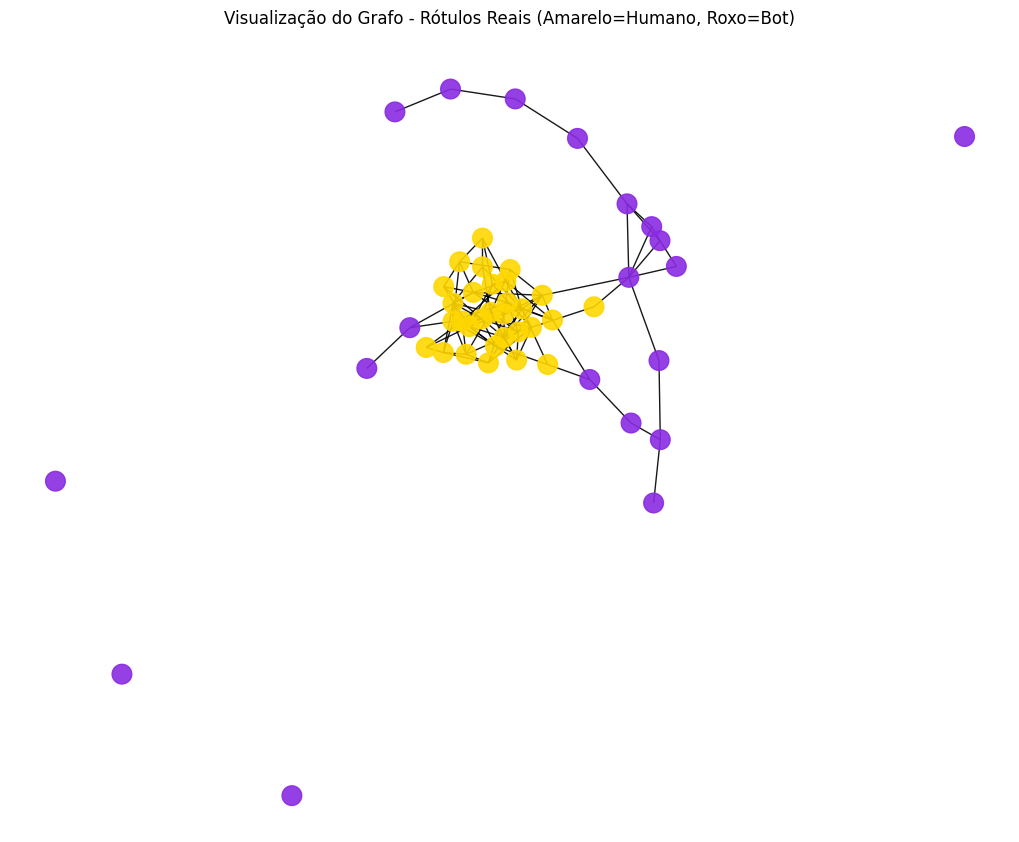

In [4]:
# Célula 4: Visualização dos Dados Reais
plt.figure(figsize=(10, 8))
colors = ['#FFD700' if data.y[i] == 0 else '#8A2BE2' for i in range(data.num_nodes)]
nx.draw(G, node_color=colors, with_labels=False, node_size=200, alpha=0.9)
plt.title("Visualização do Grafo - Rótulos Reais (Amarelo=Humano, Roxo=Bot)")
plt.show()

- Podemos notar a diferença entre interações entre humanos e interações entre bots.


# Definição do Modelo GNN

Aqui definimos a arquitetura da nossa Rede Neural de Grafo. Usaremos duas camadas GCNConv (Camadas de Convolução de Grafos), que é uma das arquiteturas mais populares

In [5]:
class GCN(torch.nn.Module):
  def __init__(self, num_node_features, num_classes):
    super(GCN, self).__init__()
    #primaira camada convolucional de grafo
    self.conv1 = GCNConv(num_node_features, 16)
    # segunda camada convolucional de grafo
    self.conv2 = GCNConv(16, num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    #Passa pela primeira camada e aplica a funcao de ativacao ReLU
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)

    # passa pela segunda camada
    x = self.conv2(x, edge_index)
    #retorna as probs com log_sofmax (bom para funcao de perda NLLLoss)
    return F.log_softmax(x, dim=1)

# Configuração do treinamento

Vamos instanciar o modelo, definir o otimizador (Adam) e a função de perda (Negative Log Likehood Loss, que funciona bem log_softmax). Também vamos criar máscaras para dividir nossos dados em treino, validação e teste

In [6]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = GCN(num_node_features = data.num_node_features, num_classes = 2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)
criterion = torch.nn.NLLLoss()

# criando mascaras de treino e teste (60% treino, 40% teste)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_end = int(0.6 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype = torch.bool)
train_mask[perm[:train_end]] = True

test_mask = torch.zeros(num_nodes, dtype = torch.bool)
test_mask[perm[train_end:]] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Loop de Treinamento
Este é o coração do nosso processo de aprendizado. Vamos treinar o modelo por 200 épocas

In [8]:
model.train()
for epoch in range(200):
  optimizer.zero_grad()
  out = model(data)

  #calculamos a loss apenas nos nós de treinamento
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  if (epoch + 1) % 20 == 0:
    print(f"Epoca: {epoch+1:03d}, Perda: {loss:.4f}")
print("-------------------\nTreinamento concluído! ")

Epoca: 020, Perda: 0.0602
Epoca: 040, Perda: 0.0172
Epoca: 060, Perda: 0.0115
Epoca: 080, Perda: 0.0110
Epoca: 100, Perda: 0.0056
Epoca: 120, Perda: 0.0043
Epoca: 140, Perda: 0.0208
Epoca: 160, Perda: 0.0019
Epoca: 180, Perda: 0.0024
Epoca: 200, Perda: 0.0030
-------------------
Treinamento concluído! 


# Avaliação do Modelo

Agora que o modelo está treinado, vamos ver o quão bem ele se sai classificando os nós do conjunto de teste, que ele nunca viu durante o treinamento

In [11]:
model.eval()
pred = model(data).argmax(dim=1)

#Verificando acuracia de nos de teste
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Acurácia no conjunto de teste: {acc:.4f}')

Acurácia no conjunto de teste: 1.0000


# Visualização dos Resultados de Previsão

Finalmente, vamos visualizar o grafo novamente, mas desta vez colorindo os nós de acordo com as previsões do nosso modelo. Compare esta imagem com a primeira para ver se a GNN conseguiu aprender a estrutura da comunidade

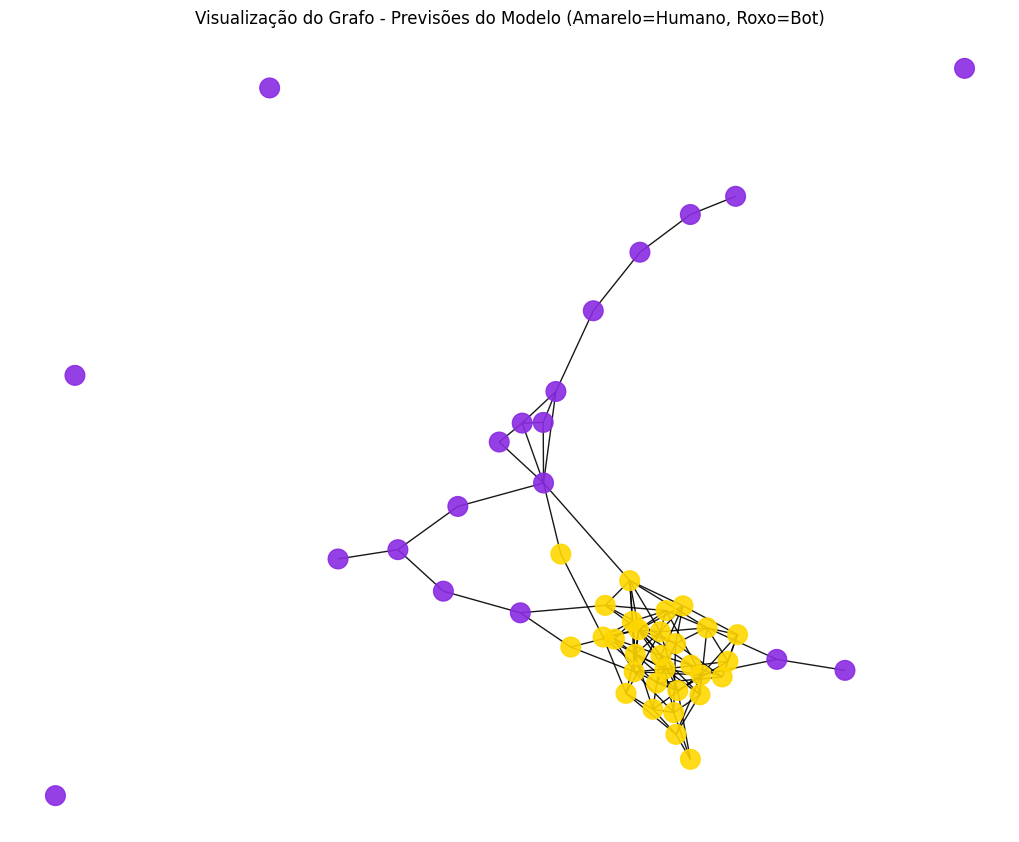

In [12]:
# Célula 9: Visualização dos Resultados da Previsão
plt.figure(figsize=(10, 8))
pred_colors = ['#FFD700' if pred[i] == 0 else '#8A2BE2' for i in range(data.num_nodes)]
nx.draw(G, node_color=pred_colors, with_labels=False, node_size=200, alpha=0.9)
plt.title("Visualização do Grafo - Previsões do Modelo (Amarelo=Humano, Roxo=Bot)")
plt.show()

# Resumo do Projeto

Este projeto demonstra o uso de Redes Neurais de Grafo (GNNs) para classificação de nós em um grafo sintético.

1.  **Geração do Grafo Sintético:** Criamos um grafo que simula uma rede social com duas comunidades distintas: "Humanos" e "Bots". Definimos a estrutura de conexão entre os nós, com humanos mais conectados entre si e bots com menos conexões e algumas ligações com humanos.
2.  **Geração de Features e Rótulos:** Atribuímos características sintéticas (como "Nível de Atividade" e "Anonimato do Perfil") e rótulos (0 para humanos, 1 para bots) a cada nó.
3.  **Preparação dos Dados:** Convertemos os dados do grafo e as features/rótulos para o formato de tensores do PyTorch, adequado para o treinamento da GNN.
4.  **Definição do Modelo GNN:** Implementamos uma rede neural de grafo simples usando duas camadas `GCNConv` da biblioteca `torch_geometric`.
5.  **Configuração e Treinamento:** Configuramos o otimizador e a função de perda, dividimos os dados em conjuntos de treino e teste usando máscaras e treinamos o modelo GNN.
6.  **Avaliação e Visualização:** Avaliamos a acurácia do modelo no conjunto de teste e visualizamos as previsões do modelo no grafo para comparar com os rótulos reais e entender como a GNN aprendeu a estrutura das comunidades.